In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Bidirectional, Dropout, Dense, Input, GlobalAveragePooling1D, Multiply, Permute, RepeatVector, Flatten, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt

2025-02-03 19:57:53.005197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 19:57:53.391074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738612673.539180    1540 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738612673.583266    1540 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 19:57:53.966508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load preprocessed data
data = np.load("../dataset.npz")
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [3]:
# Model Parameters
input_shape = X_train.shape[1:]  # (sequence_length, features)
num_classes = y_train.shape[1]     # Number of output classes

In [4]:
# Reshape data to include the channel dimension (features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
def sum_over_time(x):
    return tf.keras.backend.sum(x, axis=1)

In [6]:
# Define a simple self-attention block
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    # Learn an attention vector of size (time_steps, 1)
    a = Dense(1, activation='tanh')(inputs)
    a = Flatten()(a)
    a = Activation('softmax')(a)
    a = RepeatVector(input_dim)(a)
    a = Permute([2, 1])(a)
    # Apply the attention weights
    output = Multiply()([inputs, a])
    # Sum over time steps to get a context vector
    output = Lambda(sum_over_time)(output)
    return output

In [7]:
# Input layer
inputs = Input(shape=(X_train.shape[1], 1))

# --- Model Architecture --- #
# First Bidirectional LSTM block
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
x = Dropout(0.4)(x)

# First CNN block
x = Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Second Bidirectional LSTM block
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = Dropout(0.4)(x)

# Second CNN block
x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Third Bidirectional LSTM block
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = Dropout(0.4)(x)

# Third CNN block
x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

# Final LSTM block
x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.3)(x)

# --- Attention Block --- #
attention_output = attention_3d_block(x)

# Dense layers after attention
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(attention_output)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

I0000 00:00:1738612682.425198    1540 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
# Define and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0002), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 225, 512)  │    528,384 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 225, 512)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 223, 256)  │    393,472 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 111, 256)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 256)  │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 111, 256)  │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 111, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 109, 128)  │     98,432 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 54, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 128)   │        512 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 54, 128)   │     98,816 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 54, 128)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 52, 64)    │     24,640 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 26, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 64)    │        256 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 26, 32)    │     12,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 26, 32)    │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 26, 1)     │         33 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 26)        │          0 │ dense[0][0]     

 Total params: 1,560,964 (5.95 MB)

 Trainable params: 1,560,068 (5.95 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
# Callbacks
checkpoint = ModelCheckpoint("../model/best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)


In [10]:
# Train Model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128, 
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/100


I0000 00:00:1738612694.420727    2124 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-03 19:58:17.512024: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


891/892 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0845 - loss: 3.8310

2025-02-03 20:01:08.383004: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.0845 - loss: 3.8305
Epoch 1: val_accuracy improved from -inf to 0.11057, saving model to ../model/best_model.keras
892/892 ━━━━━━━━━━━━━━━━━━━━ 196s 206ms/step - accuracy: 0.0846 - loss: 3.8301 - val_accuracy: 0.1106 - val_loss: 3.4735 - learning_rate: 2.0000e-04
Epoch 2/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3507 - loss: 2.3707
Epoch 2: val_accuracy improved from 0.11057 to 0.54676, saving model to ../model/best_model.keras
892/892 ━━━━━━━━━━━━━━━━━━━━ 175s 196ms/step - accuracy: 0.3508 - loss: 2.3704 - val_accuracy: 0.5468 - val_loss: 1.6411 - learning_rate: 2.0000e-04
Epoch 3/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6185 - loss: 1.4619
Epoch 3: val_accuracy improved from 0.54676 to 0.71764, saving model to ../model/best_model.keras
892/892 ━━━━━━━━━━━━━━━━━━━━ 172s 193ms/step - accuracy: 0.6186 - loss: 1.4618 - val_accuracy: 0.7176 - val_loss: 1.1803 - learning_rate: 2.0000e-04
Epoch 4

In [11]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

513/513 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9867 - loss: 0.1277
Test Accuracy: 0.99


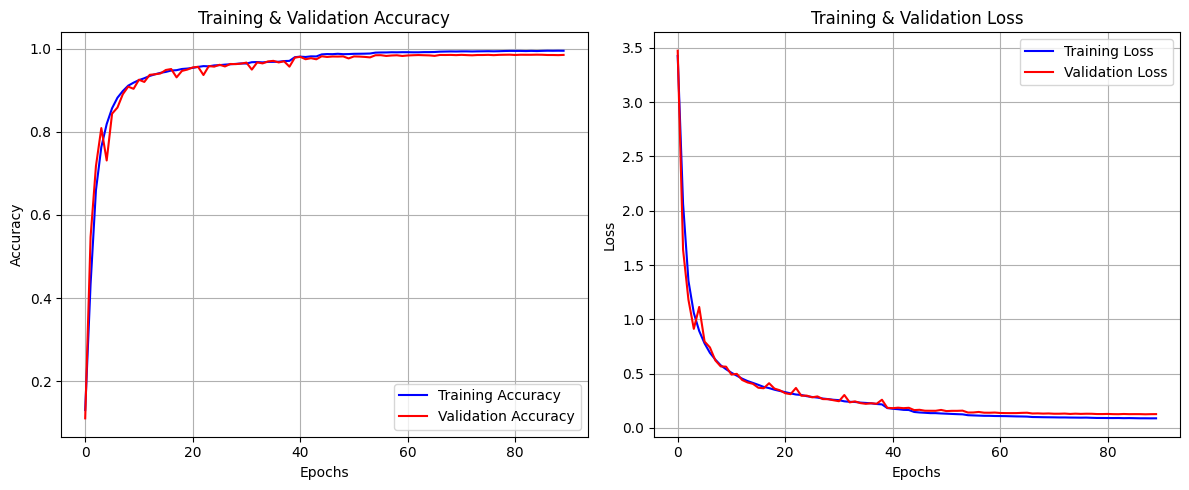

In [12]:
# Plot training history
history_dict = history.history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Training Loss", color="blue")
plt.plot(history_dict["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [13]:
# Save the final model
model.save("../model/lstm_cnn_model.keras")
print("Model training completed and saved in .keras format.")

Model training completed and saved in .keras format.
